In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sklearn
import lzma
import nltk

from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
#Any global parameters to adjust
plt.rcParams.update({'font.size': 20})
%pprint

Pretty printing has been turned OFF


<i>Replacement Notebook</i>
<h1>Phase 3</h1>
<p>We're really getting down to the wire here. The main focus will be on the machine learning, but if I can afford to, I'll do some immediate linguistics analysis.</p>

<a id="toc"></a>
<h2>Table of Contents</h2>
<ol>
    <li><a href="#loading">Loading the data and Setting Target Subreddits</a></li>
    <li><a href="#breakdown">Breakdown of Subreddits</a></li>
    <li><a href="#baseline">Baseline Machine Learning</a></li>
</ol>

<a id="loading"></a>
<h2>Loading the data and Setting the Target Subreddits [<a href="#toc">TOC</a>]</h2>
<p>So first off, we have to load the data. And then we have to set our target subreddits.</p>

In [3]:
redditframe=pd.read_pickle("../data/TokenizedRedditframe.pkl")

In [4]:
above50 = redditframe[redditframe.score >= 50]

In [5]:
targetsubreddits=["relationships", "aww", "nfl", "PrequelMemes", "gaming", "mildlyinteresting", "politics", "Showerthoughts","worldnews","gifs", "StarWars", "funny"]

In [6]:
above50t = above50[above50.subreddit.isin(targetsubreddits)]
above50t.to_pickle("../data/MLdata.pkl")

<p>The data has been loaded and the target subreddits has been set. I pickle them here so that I can scp them onto the CRC server. Let's do this.</p>

<a id="breakdown"></a>
<h2>Breakdown of Subreddits [<a href="#toc">TOC</a>]</h2>
<p>Since this wasn't covered in the previous phase, I'll have to breakdown the subreddits real quick.</p>

In [7]:
for i in targetsubreddits:
    print(len(above50t[above50t.subreddit==i]), i)

631 relationships
362 aww
1019 nfl
130 PrequelMemes
691 gaming
206 mildlyinteresting
1786 politics
479 Showerthoughts
995 worldnews
324 gifs
851 StarWars
580 funny


<p>Hmm, Politics is more disporportionate than I thought, but it's not as bad as AskReddit. I'll roll with it for now, but I might have to change it out for something else if needed.</p>

In [8]:
above50t.groupby("subreddit").score.mean()

subreddit
PrequelMemes         150.469231
Showerthoughts       400.661795
StarWars             149.481786
aww                  376.994475
funny                450.589655
gaming               419.299566
gifs                 757.317901
mildlyinteresting    492.194175
nfl                  175.197252
politics             228.754759
relationships        154.890650
worldnews            399.067337
Name: score, dtype: float64

<p>Gifs seems to have an unsually high average despite not being the smallest. Otherwise, the average seems to correlate with the size, but not alone since PrequelMemes is the smallest and has the smallest average.</p>

<a id="baseline"></a>
<h2>Baseline Machine Learning [<a href="#toc">TOC</a>]</h2>
<p>For this section, we'll run machine learning on some basic parameters, to gauge of how progress we have to do. We'll run one run of each, no cross-validation until we get to the grid search. To make things interesting, we'll use multiple machine learning algorithms. First off, we must determine the percentage of each subreddit so that we can see who is the largest, and what value the accuracy score must clear...</p>

In [9]:
#A quick function to repeatedly plot the confusionmatrices
def plotConfusionMatrix(cm):
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', square=True, cmap="icefire")
    plt.xlabel('Predicted')
    plt.ylabel('Actual Value')
    plt.show()

In [10]:
for i in targetsubreddits:
    print(len(above50t[above50t.subreddit==i])/len(above50t), i)

0.07834616339706978 relationships
0.044946610379935435 aww
0.12652098336230444 nfl
0.01614104792649615 PrequelMemes
0.08579587782468338 gaming
0.025577352868140054 mildlyinteresting
0.22175316612863175 politics
0.059473553513781974 Showerthoughts
0.123541097591259 worldnews
0.04022845790911348 gifs
0.10566178296498634 StarWars
0.07201390613359822 funny


<p>Politics makes up the largest portion at 22%. Therefore, we must get above 22% for our classifier to even be remotely classified as successful.</p>
<p>Moving on, we'll split the data for our singular basic runs.</p>

In [11]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t["body"], above50t["subreddit"], test_size = 1/5, random_state = 0)

In [12]:
vectorizer = TfidfVectorizer(min_df=2)
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=2)), ('MNB', MultinomialNB())])

In [13]:
model.fit(trainingdata, y_train)

Pipeline(memory=None,
     steps=[('Tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...rue,
        vocabulary=None)), ('MNB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [14]:
y_pred = model.predict(testingdata)
cm = pd.crosstab(y_test, y_pred)

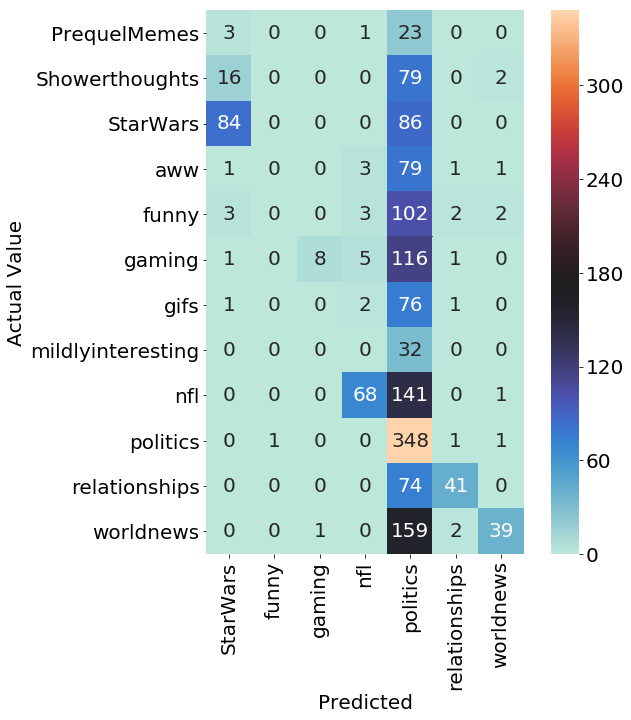

In [15]:
plotConfusionMatrix(cm)

In [16]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.3649906890130354

In [17]:
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=2)), ('SVC', SVC(kernel='linear', C=1E5))])
svd = SVC(kernel='linear', C=1E5)
model.fit(trainingdata, y_train)

Pipeline(memory=None,
     steps=[('Tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...r', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [18]:
y_pred = model.predict(testingdata)
cm = pd.crosstab(y_test, y_pred)

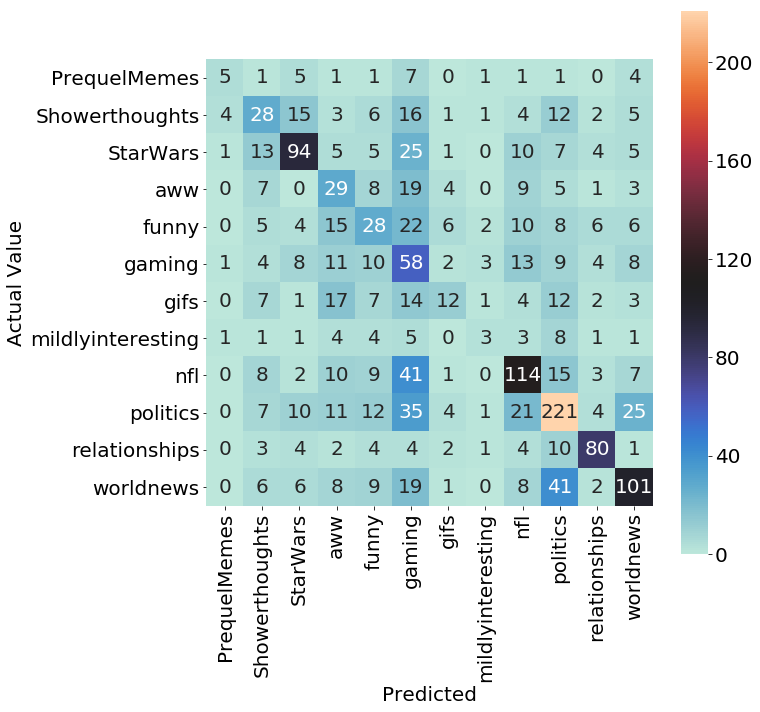

In [19]:
plotConfusionMatrix(cm)

In [20]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.4798261949099938

<p>36% and 48% for each algorithm separately. Not off to a great start, but at the same time we have lots of room for improvement.</p>

<a id="optimal"></a>
<h2>Finding the Optimal Parameters</h2>
<p>I've ported this off too the CRC to take advantage of their resources to run a lot of parameters. Let's see what the most optimal parameters are for each algorithm.</p>

In [21]:
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=1)), ('SVC', SVC(kernel='linear', C=1E5))])

In [22]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t[["author_cakeday","score"]], above50t["subreddit"], test_size = 1/5, random_state = 0)

In [23]:
model.fit(trainingdata, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [2, 6443]

In [24]:
above50t[["author_cakeday","score"]].head()

,author_cakeday,score
55,0.0,429
1591,0.0,115
1643,0.0,102
2776,0.0,290
3154,0.0,474


In [25]:
trainingdata.head()

,author_cakeday,score
311102,0.0,463
1268192,0.0,340
2129630,0.0,139
1949133,0.0,192
1740678,0.0,169


In [26]:
testthis = MultinomialNB(alpha=0.01)

In [27]:
testthis.fit(trainingdata,y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

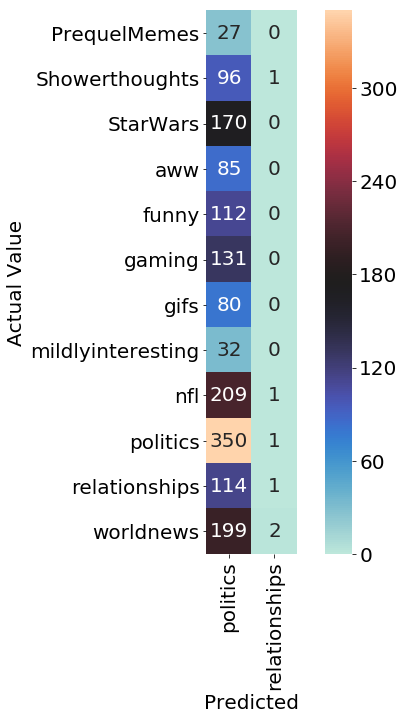

In [28]:
y_pred = testthis.predict(testingdata)
cm = pd.crosstab(y_test, y_pred)
plotConfusionMatrix(cm)

In [29]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t[["author_cakeday","score","controversiality"]], above50t["subreddit"], test_size = 1/5, random_state = 0)

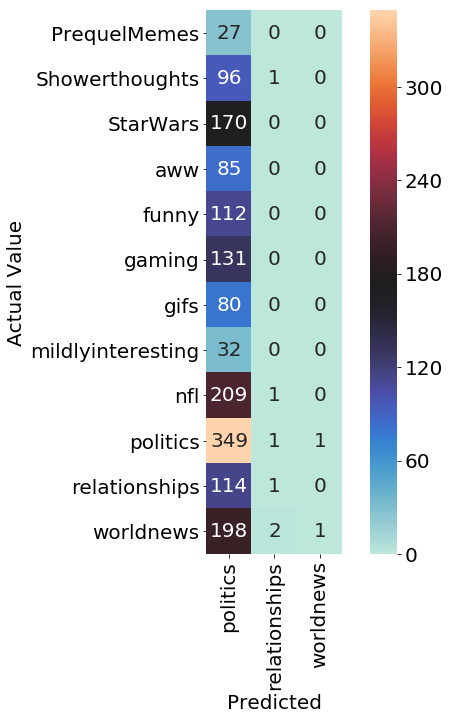

In [30]:
testthis = MultinomialNB(alpha=0.01)
testthis.fit(trainingdata,y_train)
y_pred = testthis.predict(testingdata)
cm = pd.crosstab(y_test, y_pred)
plotConfusionMatrix(cm)